In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
!pip install geopandas
!pip install pygeos
!pip install rtree

     |████████████████████████████████| 994 kB 3.2 MB/s 
     |████████████████████████████████| 6.3 MB 42.6 MB/s 
     |████████████████████████████████| 15.4 MB 84 kB/s 
     |████████████████████████████████| 1.8 MB 3.1 MB/s 
     |████████████████████████████████| 994 kB 3.1 MB/s 


In [3]:
import pandas as pd
import numpy as np
import datetime as dt
import math
import scipy.stats as sp
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd
from pandas.tseries.offsets import MonthBegin
import seaborn as sns
import statsmodels.api as sm
from shapely.geometry import Point, LineString, Polygon
import fiona

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
elements = pd.read_csv("./gdrive/MyDrive/COMP0158/London_Data_v6.csv")

In [5]:
def new_business_in_range(history, date1, date2):
    """ Qurey the data during specific period """
    new_busi = (history.query("(TS <= @date2 & TS >= @date1 & Version == 1) | (TS <= @date2 & TS >= @date1 & closure_tag != 'False')").reset_index(drop=True))
    return new_busi

def new_close_in_range(history, date1, date2):
    """ Qurey the data during specific period """
    new_close = (history.query("TS <= @date2 & TS >= @date1 & closure_tag != 'False'").reset_index(drop=True))
    return new_close

def updates_in_range(history, date1, date2):
    """ Qurey the data during specific period """
    update_busi = (history.query("TS <= @date2 & TS >= @date1 & Version != 1 & closure_tag == 'False'").reset_index(drop=True))
    return update_busi

def poi_in_range(history, date):
    """ Qurey the data before specific date/time """
    datedelems = (history.query("TS <= @date")
                  .groupby(['type','id'])['Version']
                  .max()
                  .reset_index())
    return pd.merge(datedelems, history, on=['type','id','Version'])

In [6]:
elements["YM"] = pd.to_datetime(elements["TS"]).apply(lambda x:x.strftime("%Y-%m"))

In [7]:
pre_new, post_new = new_business_in_range(elements,"2019-04-01","2020-03-31"), new_business_in_range(elements,"2020-04-01","2021-03-31")
pre_closure, post_closure = new_close_in_range(elements,"2019-04-01","2020-03-31"), new_close_in_range(elements,"2020-04-01","2021-03-31")
pre_update, post_update = updates_in_range(elements,"2019-04-01","2020-03-31"), updates_in_range(elements,"2020-04-01","2021-03-31")
#pre_poi, post_poi = gpd.GeoDataFrame(poi_in_range(elements, "2020-03-31")), gpd.GeoDataFrame(poi_in_range(elements, "2021-03-31"))

In [ ]:
pre_new

,type,id,Version,TS,Lat,Lon,amenity,name,amend_tag,amenity_group,closure_tag,previous_name,pre_amenity_group,Year,YM
0,node,7346697235,1,2020-03-30 15:05:31+00:00,51.500388,-0.074737,bicycle_parking,NaN,NaN,Transportation,False,False,Other,2020,2020-03
1,node,7344876560,1,2020-03-30 01:15:38+00:00,51.599306,-0.330767,post_box,NaN,NaN,Public_Service,False,False,Other,2020,2020-03
2,node,7344876561,1,2020-03-30 01:15:38+00:00,51.601140,-0.333951,post_box,NaN,NaN,Public_Service,False,False,Other,2020,2020-03
3,node,7344876562,1,2020-03-30 01:15:38+00:00,51.595428,-0.340332,post_box,NaN,NaN,Public_Service,False,False,Other,2020,2020-03
4,node,7343498624,1,2020-03-29 16:26:36+00:00,51.589759,-0.332497,clinic,Harrow Talking Therapies,NaN,Healthcare,False,False,Other,2020,2020-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7320,node,6375719846,1,2019-04-01 11:34:17+00:00,51.518069,-0.163467,parking_entrance,NaN,NaN,Transportation,False,False,Other,2019,2019-04
7321,node,295448577,8,2019-04-01 11:02:20+00:00,51.516560,-0.164825,restaurant,Al Arez Express,True,Sustenance,bar,Alarez Bar-Restaurant,Sustenance,2019,2019-04
7322,node,6375669141,1,2019-04-01 11:02:19+00:00,51.516624,-0.164580,restaurant,Safa Restaurant,NaN,Sustenance,False,False,Other,2019,2019-04
7323,node,255008099,3,2019-04-01 10:01:36+00:00,51.579629,-0.123084,restaurant,Paesan,True,Sustenance,restaurant,Arocaria,Sustenance,2019,2019-04


In [138]:
x = np.arange(pre_update.groupby("YM").size().index.size)
fit = np.polyfit(x, pre_update.groupby("YM").size(), deg=1)
fit_function = np.poly1d(fit)

# Bar Plot

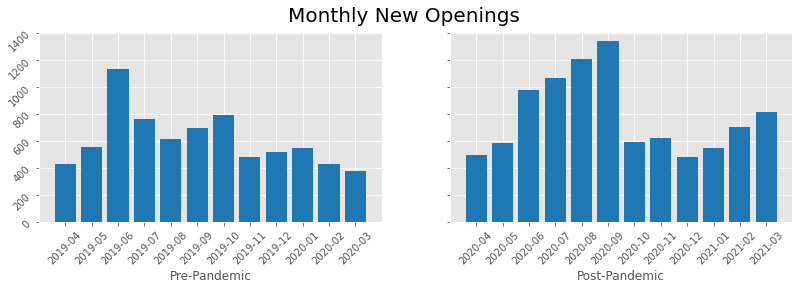

In [8]:
plt.style.use('ggplot')
f, ax = plt.subplots(1, 2, figsize=(13.5, 3.5), sharey='row')
ax[0].tick_params(labelrotation=45)

#ax[0].plot(pre_new.pivot_table(index='YM', columns='type', 
#                        aggfunc='size'),marker='o', ls=':',color="tab:purple")
ax[0].bar(pre_new.groupby("YM").size().index,pre_new.groupby("YM").size(),color="tab:blue")
#x = np.arange(pre_new.groupby("YM").size().index.size)
#fit = np.polyfit(x, pre_new.groupby("YM").size(), deg=1)
#fit_function = np.poly1d(fit)
#ax[0].plot(pre_new.groupby("YM").size().index, fit_function(x),color="tab:orange",lw=3,ls="--")
plt.setp(ax[0], xlabel='Pre-Pandemic')

ax[1].tick_params(labelrotation=45)

#ax[1].plot(post_new.pivot_table(index='YM', columns='type', 
#                        aggfunc='size'),marker='o', ls=':',color="tab:purple")
ax[1].bar(post_new.groupby("YM").size().index,post_new.groupby("YM").size(),color="tab:blue")
#x = np.arange(post_new.groupby("YM").size().index.size)
#fit = np.polyfit(x, post_new.groupby("YM").size(), deg=1)
#fit_function = np.poly1d(fit)
#ax[1].plot(post_new.groupby("YM").size().index, fit_function(x),color="tab:orange",lw=3,ls="--")
plt.setp(ax[1], xlabel='Post-Pandemic')

plt.suptitle("Monthly New Openings",fontsize=20)

plt.savefig("Monthly_New_London.png",bbox_inches = 'tight')

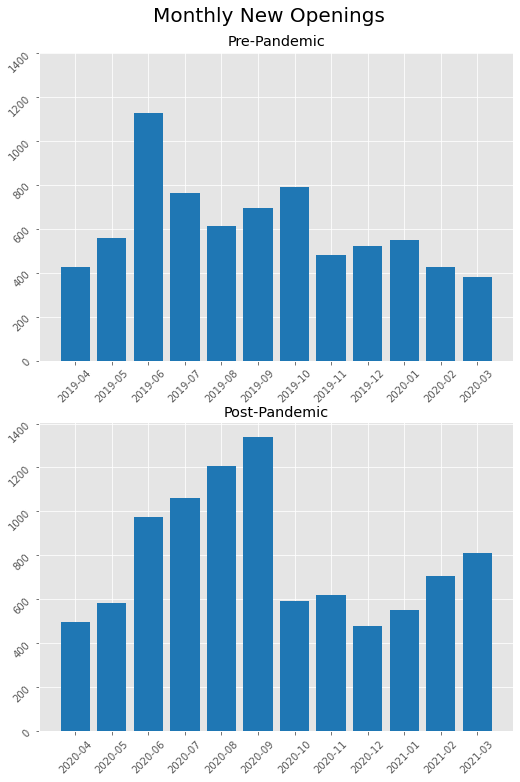

In [20]:
plt.style.use('ggplot')
f, ax = plt.subplots(2, 1, figsize=(8.5, 12.5), sharey='col')
ax[0].tick_params(labelrotation=45)


ax[0].bar(pre_new.groupby("YM").size().index,pre_new.groupby("YM").size(),color="tab:blue")
plt.setp(ax[0], title='Pre-Pandemic')

ax[1].tick_params(labelrotation=45)


ax[1].bar(post_new.groupby("YM").size().index,post_new.groupby("YM").size(),color="tab:blue")
plt.setp(ax[1], title='Post-Pandemic')

n_rows = 2
y_title_pos = ax[0].get_position().get_points()[1][1]+(1/n_rows)*0.1
plt.suptitle("Monthly New Openings",fontsize=20,y=y_title_pos)

plt.savefig("Monthly_New_London.png",bbox_inches = 'tight')

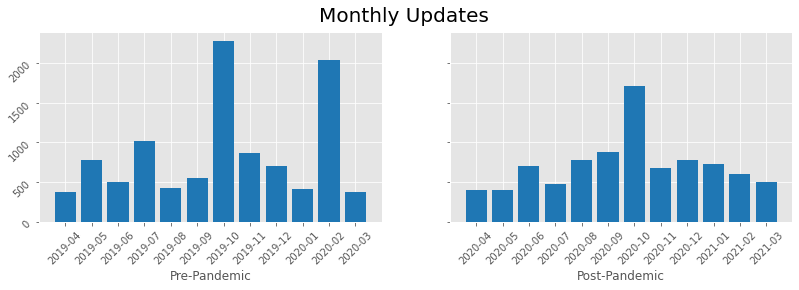

In [13]:
plt.style.use('ggplot')
f, ax = plt.subplots(1, 2, figsize=(13.5, 3.5), sharey='row')
ax[0].tick_params(labelrotation=45)

#ax[0].plot(pre_update.pivot_table(index='YM', columns='type', 
#                        aggfunc='size'),marker='o', ls=':',color="tab:purple")
ax[0].bar(pre_update.groupby("YM").size().index,pre_update.groupby("YM").size(),color="tab:blue")
#x = np.arange(pre_update.groupby("YM").size().index.size)
#fit = np.polyfit(x, pre_update.groupby("YM").size(), deg=1)
#fit_function = np.poly1d(fit)
#ax[0].plot(pre_update.groupby("YM").size().index, fit_function(x),color="tab:orange",lw=3)
plt.setp(ax[0], xlabel='Pre-Pandemic')

ax[1].tick_params(labelrotation=45)

#ax[1].plot(post_update.pivot_table(index='YM', columns='type', 
#                        aggfunc='size'),marker='o', ls=':',color="tab:orange")
ax[1].bar(post_update.groupby("YM").size().index,post_update.groupby("YM").size(),color="tab:blue")
#x = np.arange(post_update.groupby("YM").size().index.size)
#fit = np.polyfit(x, post_update.groupby("YM").size(), deg=1)
#fit_function = np.poly1d(fit)
#ax[1].plot(post_update.groupby("YM").size().index, fit_function(x),color="tab:orange",lw=3)
plt.setp(ax[1], xlabel='Post-Pandemic')

plt.suptitle("Monthly Updates",fontsize=20)

plt.savefig("Monthly_Updates_London.png",bbox_inches = 'tight')

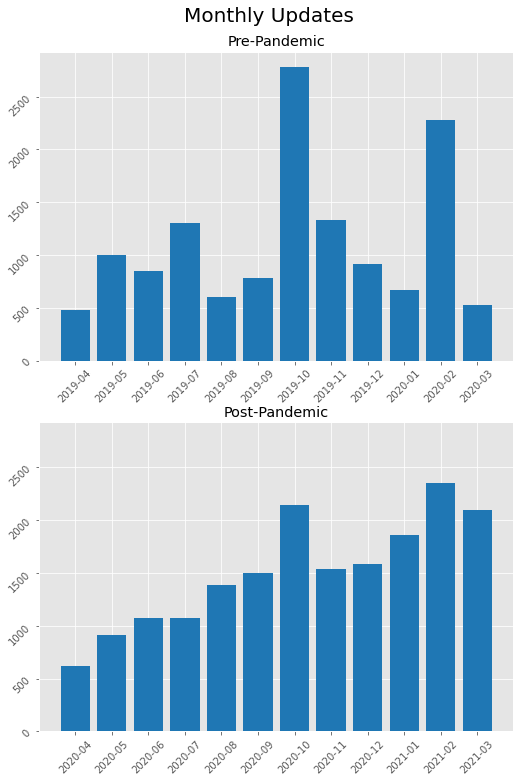

In [21]:
plt.style.use('ggplot')
f, ax = plt.subplots(2, 1, figsize=(8.5, 12.5), sharey='col')
ax[0].tick_params(labelrotation=45)


ax[0].bar(pre_update.groupby("YM").size().index,pre_update.groupby("YM").size(),color="tab:blue")
plt.setp(ax[0], title='Pre-Pandemic')

ax[1].tick_params(labelrotation=45)


ax[1].bar(post_update.groupby("YM").size().index,post_update.groupby("YM").size(),color="tab:blue")
plt.setp(ax[1], title='Post-Pandemic')

n_rows = 2
y_title_pos = ax[0].get_position().get_points()[1][1]+(1/n_rows)*0.1
plt.suptitle("Monthly Updates",fontsize=20,y=y_title_pos)

plt.savefig("Monthly_Updates_London.png",bbox_inches = 'tight')

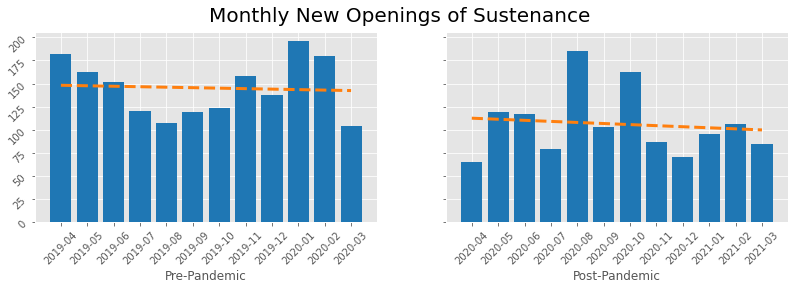

In [140]:
grp = "Sustenance"

plt.style.use('ggplot')
f, ax = plt.subplots(1, 2, figsize=(13.5, 3.5), sharey='row')
ax[0].tick_params(labelrotation=45)

#ax[0].plot(pre_new.pivot_table(index='YM', columns='type', 
#                        aggfunc='size'),marker='o', ls=':',color="tab:purple")
ax[0].bar(pre_new[pre_new["amenity_group"]==grp].groupby("YM").size().index,pre_new[pre_new["amenity_group"]==grp].groupby("YM").size(),color="tab:blue")
x = np.arange(pre_new[pre_new["amenity_group"]==grp].groupby("YM").size().index.size)
fit = np.polyfit(x, pre_new[pre_new["amenity_group"]==grp].groupby("YM").size(), deg=1)
fit_function = np.poly1d(fit)
ax[0].plot(pre_new[pre_new["amenity_group"]==grp].groupby("YM").size().index, fit_function(x),color="tab:orange",lw=3,ls="--")
plt.setp(ax[0], xlabel='Pre-Pandemic')

ax[1].tick_params(labelrotation=45)

#ax[1].plot(post_new.pivot_table(index='YM', columns='type', 
#                        aggfunc='size'),marker='o', ls=':',color="tab:purple")
ax[1].bar(post_new[post_new["amenity_group"]==grp].groupby("YM").size().index,post_new[post_new["amenity_group"]==grp].groupby("YM").size(),color="tab:blue")
x = np.arange(post_new[post_new["amenity_group"]==grp].groupby("YM").size().index.size)
fit = np.polyfit(x, post_new[post_new["amenity_group"]==grp].groupby("YM").size(), deg=1)
fit_function = np.poly1d(fit)
ax[1].plot(post_new[post_new["amenity_group"]==grp].groupby("YM").size().index, fit_function(x),color="tab:orange",lw=3,ls="--")
plt.setp(ax[1], xlabel='Post-Pandemic')

plt.suptitle("Monthly New Openings of "+grp,fontsize=20)

plt.savefig(grp+"_London.png",bbox_inches = 'tight')

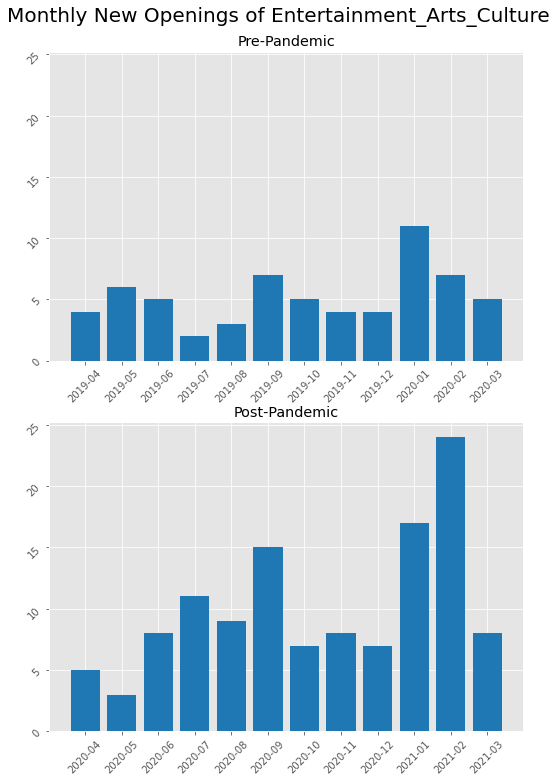

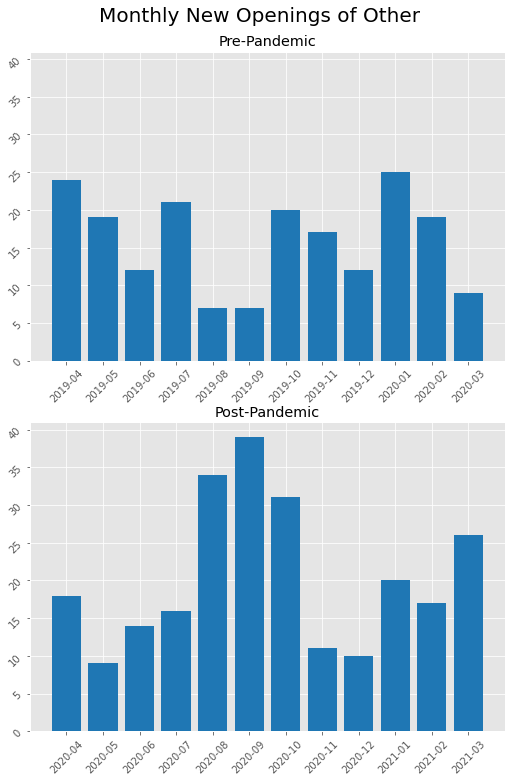

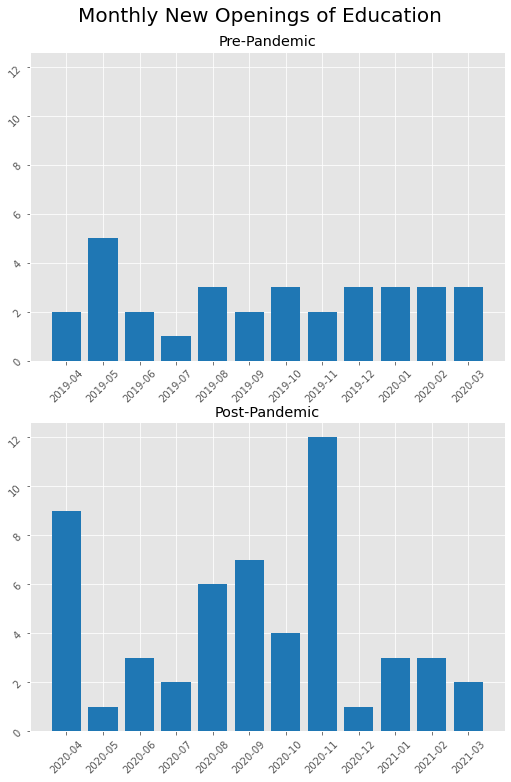

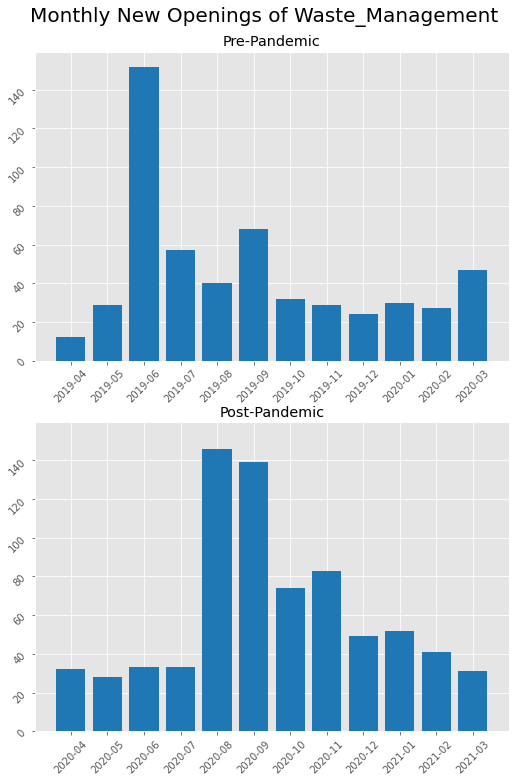

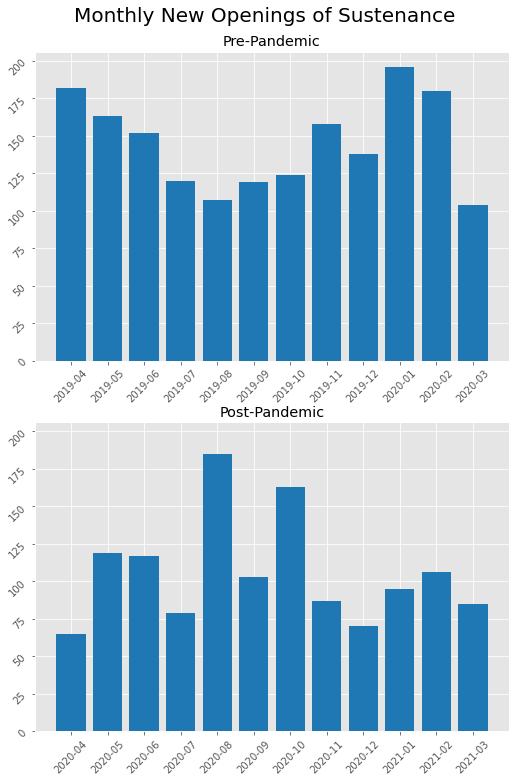

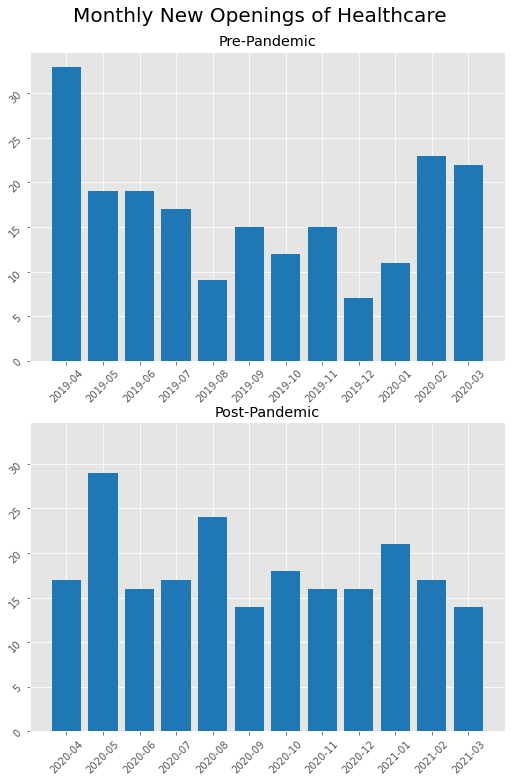

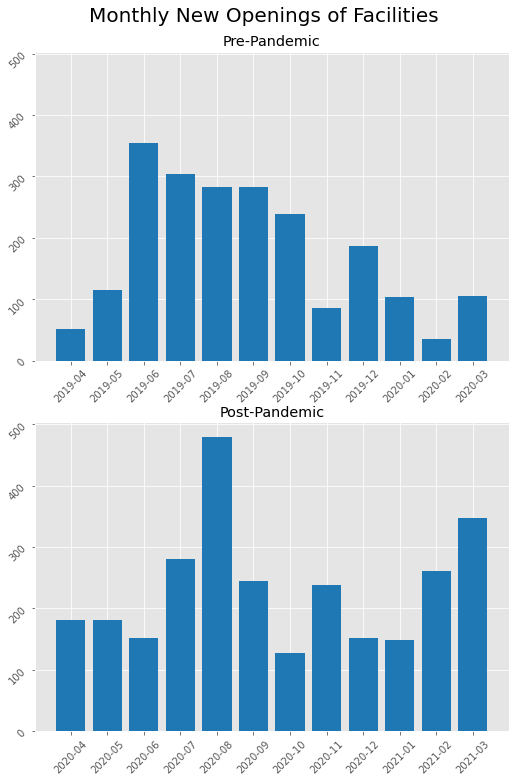

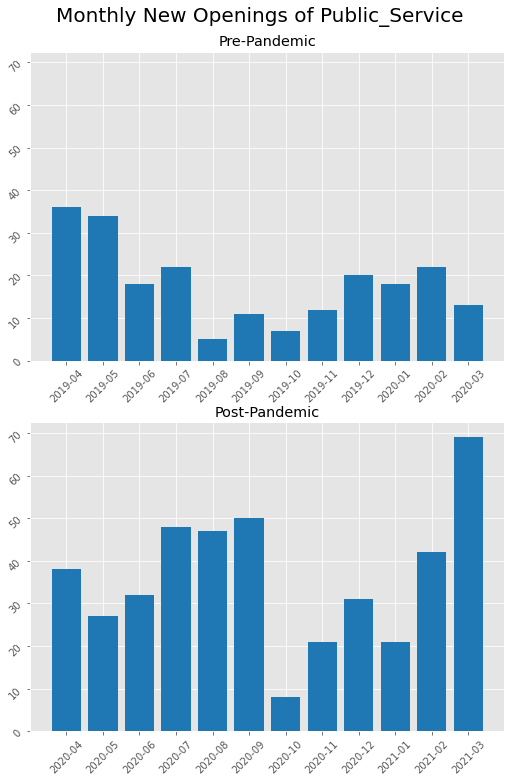

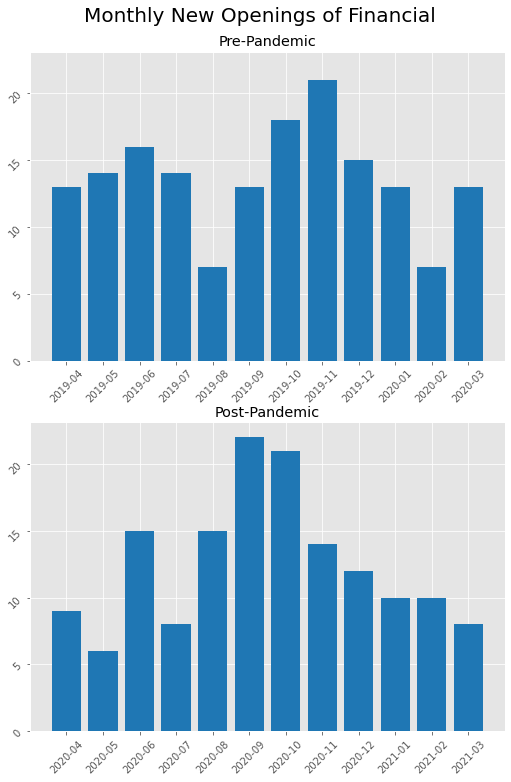

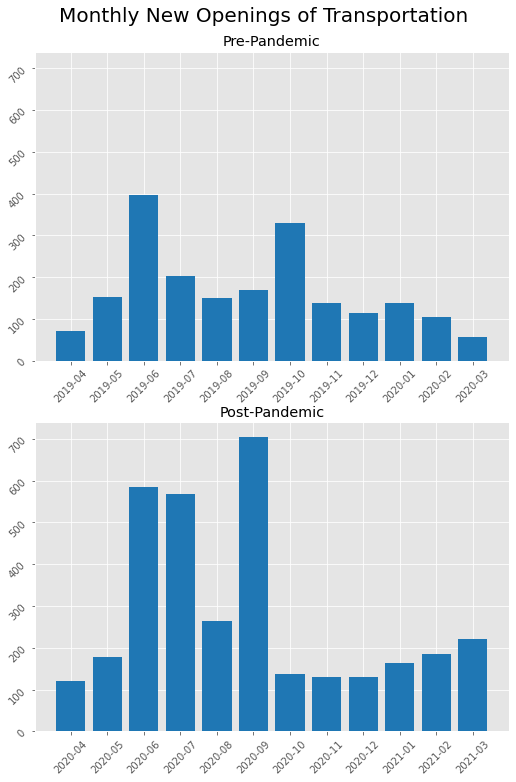

In [14]:
for grp in set(pre_new["amenity_group"]):
#grp = "Sustenance"

    plt.style.use('ggplot')
    f, ax = plt.subplots(2, 1, figsize=(8.5, 12.5), sharey='col')
    ax[0].tick_params(labelrotation=45)


    ax[0].bar(pre_new[pre_new["amenity_group"]==grp].groupby("YM").size().index,pre_new[pre_new["amenity_group"]==grp].groupby("YM").size(),color="tab:blue")
    plt.setp(ax[0], title='Pre-Pandemic')

    ax[1].tick_params(labelrotation=45)


    ax[1].bar(post_new[post_new["amenity_group"]==grp].groupby("YM").size().index,post_new[post_new["amenity_group"]==grp].groupby("YM").size(),color="tab:blue")
    plt.setp(ax[1], title='Post-Pandemic')

    n_rows = 2
    y_title_pos = ax[0].get_position().get_points()[1][1]+(1/n_rows)*0.1
    plt.suptitle("Monthly New Openings of "+grp,fontsize=20,y=y_title_pos)

    plt.savefig(grp+"_New_London.png",bbox_inches = 'tight')

In [ ]:
for grp in set(pre_update["amenity_group"]):
#grp = "Sustenance"

    plt.style.use('ggplot')
    f, ax = plt.subplots(2, 1, figsize=(8.5, 12.5), sharey='col')
    ax[0].tick_params(labelrotation=45)


    ax[0].bar(pre_update[pre_update["amenity_group"]==grp].groupby("YM").size().index,pre_update[pre_update["amenity_group"]==grp].groupby("YM").size(),color="tab:blue")
    plt.setp(ax[0], title='Pre-Pandemic')

    ax[1].tick_params(labelrotation=45)


    ax[1].bar(post_update[post_update["amenity_group"]==grp].groupby("YM").size().index,post_update[post_update["amenity_group"]==grp].groupby("YM").size(),color="tab:blue")
    plt.setp(ax[1], title='Post-Pandemic')

    n_rows = 2
    y_title_pos = ax[0].get_position().get_points()[1][1]+(1/n_rows)*0.1
    plt.suptitle("Monthly Updates of "+grp,fontsize=20,y=y_title_pos)

    plt.savefig(grp+"_Updates_London.png",bbox_inches = 'tight')

In [34]:
pre_update["count"] = 1
post_update["count"] = 1

pre_new["count"] = 1
post_new["count"] = 1

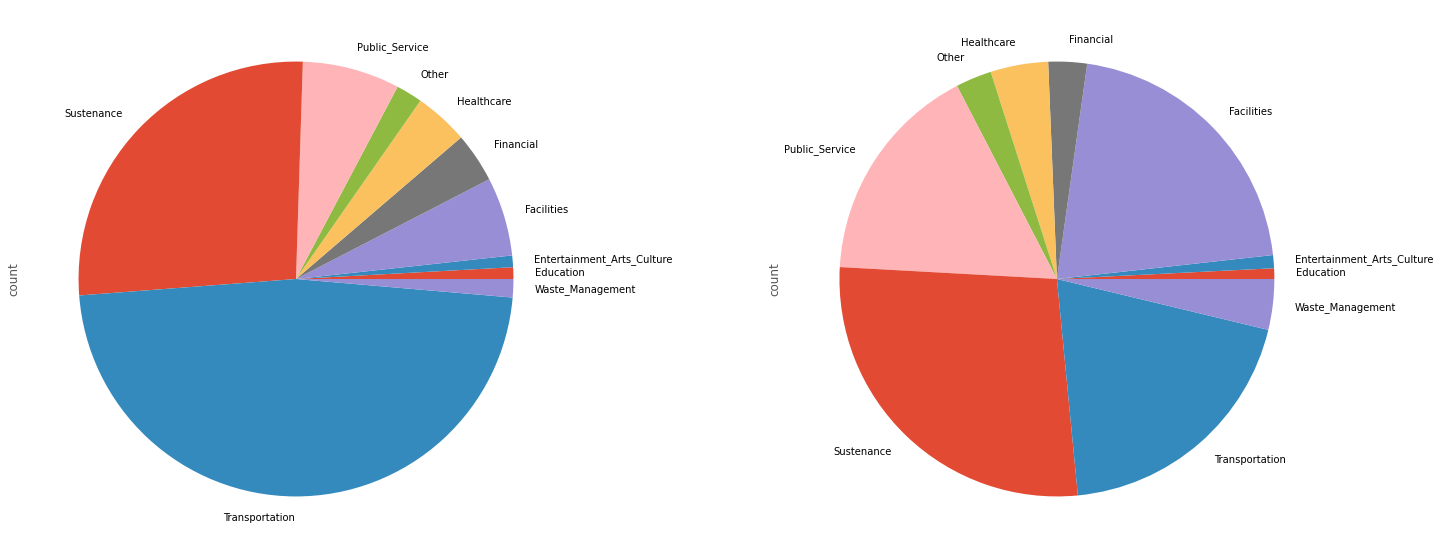

In [33]:
f, ax = plt.subplots(1, 2, figsize=(25, 10))

pre_update.groupby(['amenity_group']).sum().plot(kind='pie', y='count', ax=ax[0],legend=None)
post_update.groupby(['amenity_group']).sum().plot(kind='pie', y='count', ax=ax[1],legend=None)

plt.show()

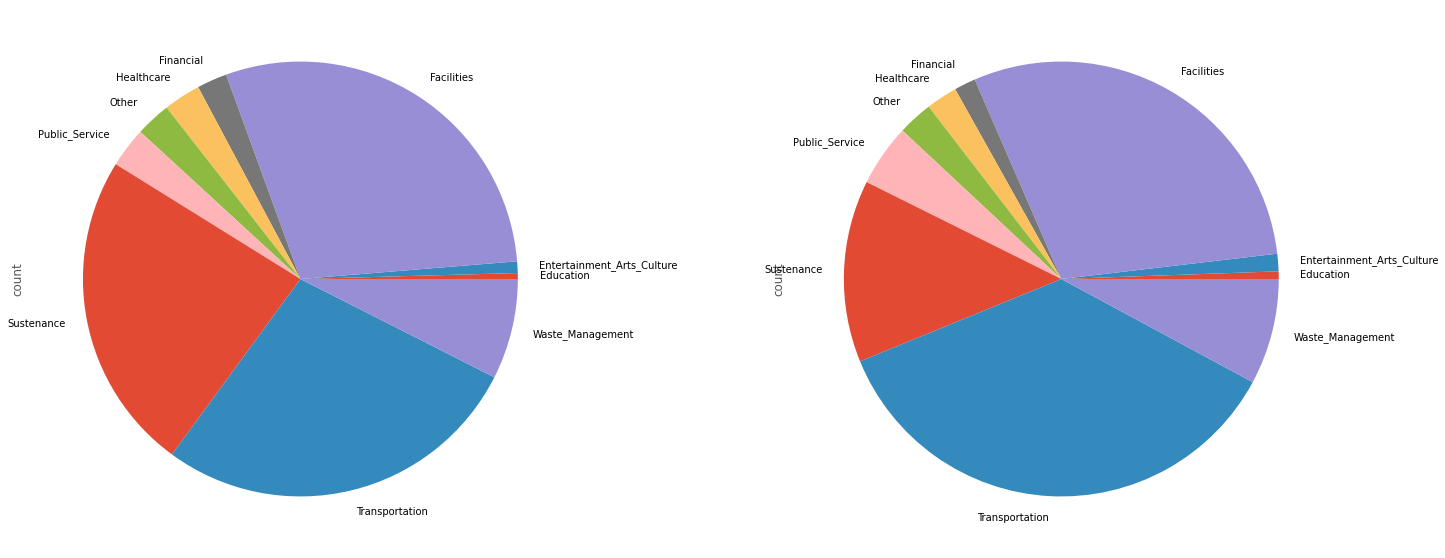

In [36]:
f, ax = plt.subplots(1, 2, figsize=(25, 10))

pre_new.groupby(['amenity_group']).sum().plot(kind='pie', y='count', ax=ax[0],legend=None)
post_new.groupby(['amenity_group']).sum().plot(kind='pie', y='count', ax=ax[1],legend=None)

plt.show()

In [ ]:
set(pre_new["amenity_group"])

{'Education',
 'Entertainment_Arts_Culture',
 'Facilities',
 'Financial',
 'Healthcare',
 'Other',
 'Public_Service',
 'Sustenance',
 'Transportation',
 'Waste_Management'}

In [38]:
set(pre_new[pre_new["amenity_group"]=="Transportation"]["amenity"])

{'bicycle_parking',
 'bicycle_rental',
 'bicycle_repair_station',
 'bus_station',
 'car_rental',
 'car_sharing',
 'car_wash',
 'charging_station',
 'ferry_terminal',
 'fuel',
 'grit_bin',
 'motorcycle_parking',
 'parking',
 'parking_entrance',
 'parking_space',
 'taxi'}

# Choropleth Map

In [48]:
import geopandas as gpd

In [156]:
polygons = gpd.read_file('./gdrive/MyDrive/COMP0158/London_2011/London_Ward_CityMerged.shp')
elements = pd.read_csv("./gdrive/MyDrive/COMP0158/London_Data_v6.csv")

elements = gpd.GeoDataFrame(elements,
                            geometry = gpd.points_from_xy(elements.Lon, elements.Lat),
                            crs=4326)
polygons = polygons.to_crs(4326)

polygons["Centroid"]=polygons['geometry'].centroid
polygons["dist_to_centre"] = polygons.distance(Point(-0.118092,51.509865))
polygons["log_dist_to_centre"] = np.log(polygons["dist_to_centre"])

elements = elements.to_crs(polygons.crs)

elements = gpd.sjoin(elements, polygons)
elements = elements.rename({'NAME':'Ward'}, axis='columns')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [157]:
# Covid Data
London_Covid = pd.read_csv("./gdrive/MyDrive/COMP0158/phe_cases_london_boroughs.csv")

# London Census Data
London_Census = pd.read_csv("./gdrive/MyDrive/COMP0158/Census by Ward.csv", encoding='latin1')

# IMD Data
IMD_Data = pd.read_excel("./gdrive/MyDrive/COMP0158/Deprivation Score/ID 2019 for London.xlsx", index_col=None,
                         sheet_name='IMD 2019')
# LSOA Mapping
LSOA_Mapping_1 = pd.read_csv("./gdrive/MyDrive/COMP0158/Deprivation Score/LSOA 2011 Mapping.csv")
LSOA_Mapping_2 = pd.read_csv("./gdrive/MyDrive/COMP0158/Deprivation Score/LSOA Mapping 2011.csv")
LSOA_Mapping = LSOA_Mapping_2.merge(LSOA_Mapping_1, how='left', left_on='OA11CD', right_on='OA11CD')

In [158]:
IMD_Data_Mini = IMD_Data[["LSOA code (2011)","Index of Multiple Deprivation (IMD) Score"]]
IMD_Data_Mini = IMD_Data_Mini.rename({"LSOA code (2011)":"LSOA_CD",
                                      "Index of Multiple Deprivation (IMD) Score":"IMD Score"}, axis='columns')

LSOA_Mapping_Mini = LSOA_Mapping[['LSOA11CD','Ward11CD']]
LSOA_Mapping_Mini = LSOA_Mapping_Mini.rename({'LSOA11CD':"LSOA_CD",
                                              "Ward11CD":"GSS_CODE"}, axis='columns')

IMD_Data_Mini = IMD_Data_Mini.merge(LSOA_Mapping_Mini, how='left', left_on='LSOA_CD', right_on='LSOA_CD')
IMD_Data_Mini = IMD_Data_Mini.drop_duplicates()
IMD_Data_Mini.groupby(['GSS_CODE']).mean()
IMD_Data_Mini = pd.DataFrame(IMD_Data_Mini.groupby(['GSS_CODE']).mean().to_records())

In [159]:
# London Census Data
London_Census = pd.read_csv("./gdrive/MyDrive/COMP0158/Census by Ward.csv", encoding='latin1')

# Extracting the ward names from originals
London_Census['Ward name'] = London_Census['Ward name'].apply(lambda x: x.split("-")[-1].strip())
London_Census = London_Census.drop(0)

# Renaming the desired columns
London_Census = London_Census.rename({'Ward name':'Ward',
                                      "New code":"New_Code",
                                      "Area - Square Kilometres":"Area",
                                      '% BAME - 2011':'BAME_Rate',
                                      "Population - 2015" : "Population",
                                      'Population density (persons per sq km) - 2013':"Population_Density",
                                      "Median House Price (£) - 2014":"Median_House_Price",
                                      "Mean Age - 2013":"Mean_Age",
                                      "Median Age - 2013":"Median_Age",
                                      "Employment rate (16-64) - 2011":"Employment_Rate",
                                      "Number of properties sold - 2014":"Properties_Sold",
                                      "Number of jobs in area - 2013":"Number_of_jobs_in_area",
                                      "Median Household income estimate (2012/13)":"Median_Household_income_estimate"}, axis='columns')
# Subseting the wanted 
London_Census = London_Census[['Ward',"New_Code","Area",'BAME_Rate',"Population","Population_Density","Median_House_Price",
                               "Mean_Age","Median_Age","Employment_Rate", "Properties_Sold","Number_of_jobs_in_area","Median_Household_income_estimate"]]
# Merge with IMD Data                               
London_Census = London_Census.merge(IMD_Data_Mini, how='left', left_on='New_Code', right_on='GSS_CODE')

# Log Transform Data
London_Census["log_Median_House_Price"] = np.log(London_Census["Median_House_Price"])
London_Census["log_Properties_Sold"] = np.log(London_Census["Properties_Sold"])

# Left Join with OSM Edit History
# elements = elements.merge(London_Census,how='left', left_on='Ward', right_on='Ward')

In [160]:
London_Census = London_Census.merge(polygons[['GSS_CODE','dist_to_centre']], how='left', left_on='New_Code', right_on='GSS_CODE')

In [161]:
# To summarize information from dataframe in order to perform regression
def df_summary(df1,df2,df3):
    """
    df1 := creation/deletion/update historical records
    df2 := Other Information to include (Independent Variables)
    df3 := historical records of editions
    """
    # Formatting Time Stamp of each record into a monthly manner
    df1['TS'] = pd.to_datetime(pd.to_datetime(df1['TS']).dt.date)
    df1['TS'] = df1['TS'].apply(lambda x: x + MonthEnd(0) - MonthBegin(1))

    # Create Pivot table of Monthly total cases
    pivot_1 = df1.pivot_table(values='id', index='TS', columns='GSS_CODE', aggfunc=pd.Series.nunique)
    pivot_agg = pd.DataFrame(pivot_1.to_records())
    pivot_agg = pivot_agg.drop(["TS"],axis=1)
    pivot_agg = pivot_agg.sum().to_frame().reset_index()
    pivot_agg = pivot_agg.rename({"index":"GSS_CODE",0:"Metric"},axis='columns')
    
    # Count total # of POIs within areas
    poi_agg = df3.pivot_table(values='id', columns='GSS_CODE', aggfunc=pd.Series.nunique)
    poi_agg  = pd.DataFrame(poi_agg.to_records())
    poi_agg = poi_agg.drop(["index"],axis=1).T.reset_index()
    poi_agg = poi_agg.rename({"index":"GSS_CODE",0:"Total_POI"},axis='columns')

    # Merge other information at a spatial unit level
    new_data = df2.merge(pivot_agg, how='left', left_on='New_Code', right_on='GSS_CODE')
    new_data = new_data.merge(poi_agg, how='left', left_on='New_Code', right_on='GSS_CODE')

    # Normalization by area size
    new_data["Metric_Ratio"] = new_data["Metric"]/new_data["Area"]
    new_data["log_Metric"] = np.log(new_data["Metric"]/new_data["Area"])
    new_data = new_data.drop(["GSS_CODE_x","GSS_CODE_y"],axis=1)

    return new_data

# Merging information with Polygons Dataframe
def Merge_with_Polygons(polygons, df):
    new_polygons = polygons.merge(df, how='left', left_on='GSS_CODE', right_on='New_Code')
    new_polygons['log_Metric'] = new_polygons['log_Metric'].fillna(np.log(0.1))
    #new_polygons.loc[new_polygons['log_Metric']<np.log(0.1),"log_Metric"] = np.log(0.05)
    return new_polygons


In [162]:
pre_new, post_new = new_business_in_range(elements,"2019-04-01","2020-03-31"), new_business_in_range(elements,"2020-04-01","2021-03-31")
pre_closure, post_closure = new_close_in_range(elements,"2019-04-01","2020-03-31"), new_close_in_range(elements,"2020-04-01","2021-03-31")
pre_update, post_update = updates_in_range(elements,"2019-04-01","2020-03-31"), updates_in_range(elements,"2020-04-01","2021-03-31")
pre_poi, post_poi = gpd.GeoDataFrame(poi_in_range(elements, "2020-03-31")), gpd.GeoDataFrame(poi_in_range(elements, "2021-03-31"))

In [163]:
# Opening
pre_new_data = df_summary(pre_new,London_Census,pre_poi)
post_new_data = df_summary(post_new,London_Census,post_poi)
pre_new_polygons = Merge_with_Polygons(polygons, pre_new_data)
post_new_polygons = Merge_with_Polygons(polygons, post_new_data)

# Closure
pre_closure_data = df_summary(pre_closure,London_Census,pre_poi)
post_closure_data = df_summary(post_closure,London_Census,post_poi)
pre_closure_polygons = Merge_with_Polygons(polygons, pre_closure_data)
post_closure_polygons = Merge_with_Polygons(polygons, post_closure_data)

# Update
pre_update_data = df_summary(pre_update,London_Census,pre_poi)
post_update_data = df_summary(post_update,London_Census,post_poi)
pre_update_polygons = Merge_with_Polygons(polygons, pre_update_data)
post_update_polygons = Merge_with_Polygons(polygons, post_update_data)

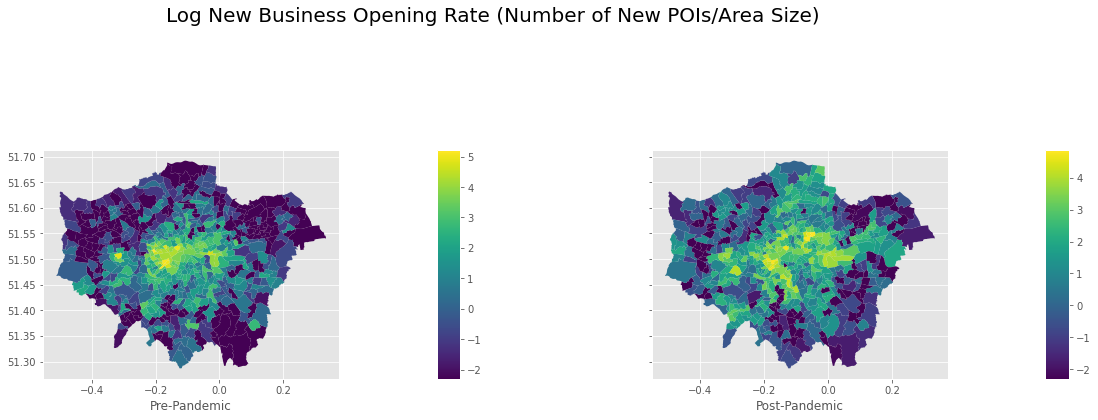

In [164]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, 2, figsize=(20, 7.5), sharey='row')

#new_polygons.plot(column='Sustenance', ax=ax, legend=True)

new_polygons1 = Merge_with_Polygons(polygons, pre_new_data)

new_polygons2 = Merge_with_Polygons(polygons, post_new_data)

divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.1)
new_polygons1.plot(column='log_Metric', ax=ax[0], legend=True, cax=cax)
plt.setp(ax[0], xlabel='Pre-Pandemic')

divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.1)
new_polygons2.plot(column='log_Metric', ax=ax[1], legend=True, cax=cax)
plt.setp(ax[1], xlabel='Post-Pandemic')

plt.suptitle("Log New Business Opening Rate (Number of New POIs/Area Size)",fontsize=20)

plt.savefig("New_Opening_Heatmap.jpg",bbox_inches = 'tight')

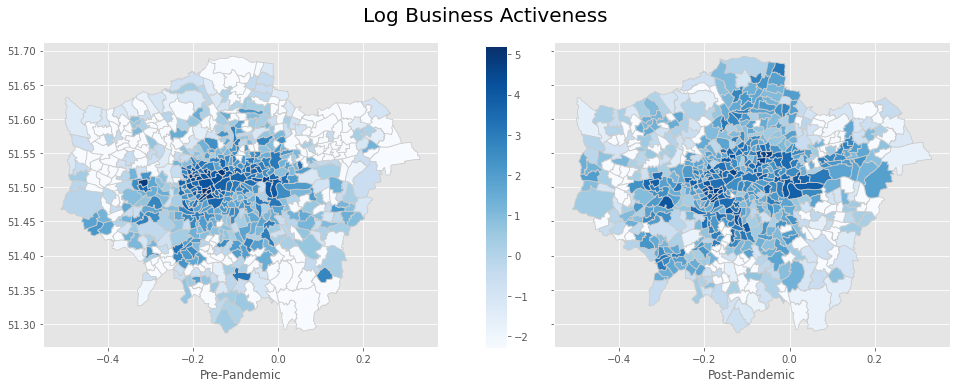

In [165]:
style = "Blues"
# set the value column that will be visualised
variable = 'log_Metric'
# set the range for the choropleth values
vmin, vmax = min(new_polygons1[variable].tolist()+new_polygons2[variable].tolist()), max(new_polygons1[variable].tolist()+new_polygons2[variable].tolist())

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1,2, figsize=(15, 5), sharey='row')

n_rows = 1
n_col = 2
# remove the axis
# ax[0].axis('off')
# ax[1].axis('off')
# add a title and annotation

# ax.set_title('# of Cities per each Region', fontdict={'fontsize': '25', 'fontweight' : '3'})
# ax.annotate('Source: Wikipedia - https://en.wikipedia.org/wiki/Provinces_of_Indonesia', xy=(0.6, .05), xycoords='figure fraction', fontsize=12, color='#555555')

# Create colorbar legend
sm = plt.cm.ScalarMappable(cmap=style, norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm.set_array([]) # or alternatively sm._A = []. Not sure why this step is necessary, but many recommends it
# add the colorbar to the figure
# fig.colorbar(sm, ax=ax.ravel().tolist())
# create map
new_polygons1.plot(column=variable, cmap=style, linewidth=0.8, ax=ax[0], edgecolor='0.8', vmin=vmin, vmax=vmax)
plt.setp(ax[0], xlabel='Pre-Pandemic')
new_polygons2.plot(column=variable, cmap=style, linewidth=0.8, ax=ax[1], edgecolor='0.8', vmin=vmin, vmax=vmax)
plt.setp(ax[1], xlabel='Post-Pandemic')

fig.tight_layout()
#fig.colorbar(sm, orientation="horizontal", fraction=0.036, pad=0.1, aspect = 30, ax=ax.ravel().tolist())
y_title_pos = ax[0].get_position().get_points()[1][1]+(1/n_rows)*0.1
plt.suptitle("Log Business Activeness",fontsize=20,y=y_title_pos)
# fig.colorbar(sm, ax=ax.ravel().tolist(),aspect = 30, fraction=0.036, cax = fig.add_axes([0.09, 0 , 0.84, 0.02]), orientation="horizontal")
fig.colorbar(sm, ax=ax.ravel().tolist(),aspect = 30, fraction=0.036, cax = fig.add_axes([0.5, 0.12 , 0.02, 0.84]))
plt.savefig("New_Choropleth_Map.png" ,bbox_inches = 'tight')
# plt.show()

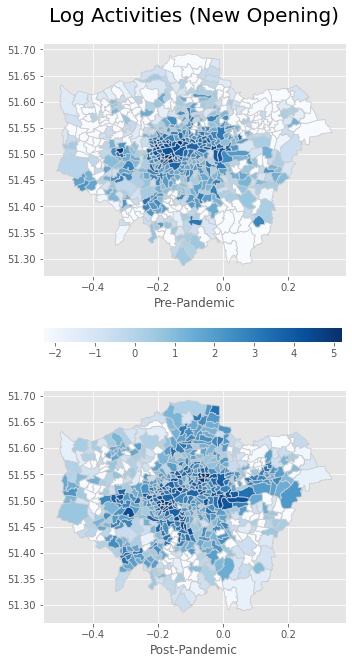

In [166]:
style = "Blues"

# set the value column that will be visualised
variable = 'log_Metric'
# set the range for the choropleth values
vmin, vmax = min(new_polygons1[variable].tolist()+new_polygons2[variable].tolist()), max(new_polygons1[variable].tolist()+new_polygons2[variable].tolist())

# create figure and axes for Matplotlib
fig, ax = plt.subplots(2,1, figsize=(5, 10), sharey='row')

n_rows = 2
n_col = 1
# remove the axis
# ax[0].axis('off')
# ax[1].axis('off')
# add a title and annotation

# ax.set_title('# of Cities per each Region', fontdict={'fontsize': '25', 'fontweight' : '3'})
# ax.annotate('Source: Wikipedia - https://en.wikipedia.org/wiki/Provinces_of_Indonesia', xy=(0.6, .05), xycoords='figure fraction', fontsize=12, color='#555555')

# Create colorbar legend
sm = plt.cm.ScalarMappable(cmap=style, norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm.set_array([]) # or alternatively sm._A = []. Not sure why this step is necessary, but many recommends it
# add the colorbar to the figure
# fig.colorbar(sm, ax=ax.ravel().tolist())
# create map
new_polygons1.plot(column=variable, cmap=style, linewidth=0.8, ax=ax[0], edgecolor='0.8')#, vmin=vmin, vmax=vmax)
plt.setp(ax[0], xlabel='Pre-Pandemic')
new_polygons2.plot(column=variable, cmap=style, linewidth=0.8, ax=ax[1], edgecolor='0.8')#, vmin=vmin, vmax=vmax)
plt.setp(ax[1], xlabel='Post-Pandemic')

fig.tight_layout()
#fig.colorbar(sm, orientation="horizontal", fraction=0.036, pad=0.1, aspect = 30, ax=ax.ravel().tolist())
y_title_pos = ax[0].get_position().get_points()[1][1]+(1/n_rows)*0.1
plt.suptitle("Log Activities (New Opening)",fontsize=20,y=y_title_pos,x=0.55)
fig.colorbar(sm, ax=ax.ravel().tolist(),aspect = 30, fraction=0.036, cax = fig.add_axes([0.13, 0.5 , 0.83, 0.02]), orientation="horizontal")
#fig.colorbar(sm, ax=ax.ravel().tolist(),aspect = 30, fraction=0.036, cax = fig.add_axes([0.5, 0.12 , 0.02, 0.84]))
plt.savefig("New_Choropleth_Map.png" ,bbox_inches = 'tight',dpi=200)
# plt.show()

## Update data

In [168]:
new_polygons1 = Merge_with_Polygons(polygons, pre_update_data)

new_polygons2 = Merge_with_Polygons(polygons, post_update_data)

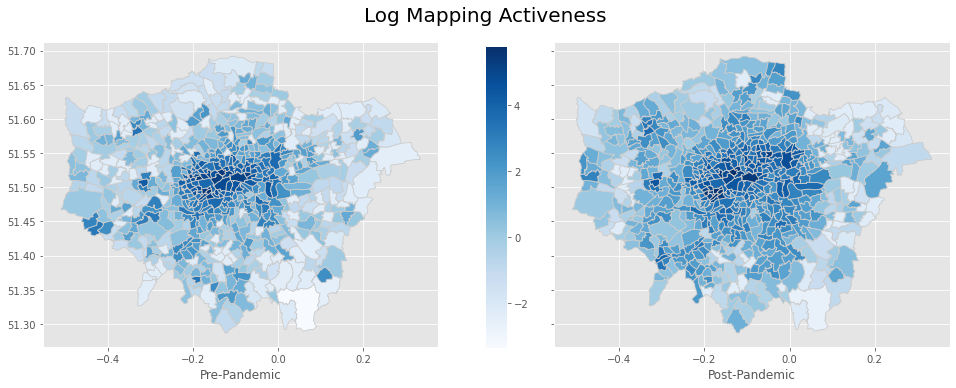

In [ ]:
style = "Blues"
# set the value column that will be visualised
variable = 'log_Metric'
# set the range for the choropleth values
vmin, vmax = min(new_polygons1[variable].tolist()+new_polygons2[variable].tolist()), max(new_polygons1[variable].tolist()+new_polygons2[variable].tolist())

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1,2, figsize=(15, 5), sharey='row')

n_rows = 1
n_col = 2
# remove the axis
# ax[0].axis('off')
# ax[1].axis('off')
# add a title and annotation

# ax.set_title('# of Cities per each Region', fontdict={'fontsize': '25', 'fontweight' : '3'})
# ax.annotate('Source: Wikipedia - https://en.wikipedia.org/wiki/Provinces_of_Indonesia', xy=(0.6, .05), xycoords='figure fraction', fontsize=12, color='#555555')

# Create colorbar legend
sm = plt.cm.ScalarMappable(cmap=style, norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm.set_array([]) # or alternatively sm._A = []. Not sure why this step is necessary, but many recommends it
# add the colorbar to the figure
# fig.colorbar(sm, ax=ax.ravel().tolist())
# create map
new_polygons1.plot(column=variable, cmap=style, linewidth=0.8, ax=ax[0], edgecolor='0.8', vmin=vmin, vmax=vmax)
plt.setp(ax[0], xlabel='Pre-Pandemic')
new_polygons2.plot(column=variable, cmap=style, linewidth=0.8, ax=ax[1], edgecolor='0.8', vmin=vmin, vmax=vmax)
plt.setp(ax[1], xlabel='Post-Pandemic')

fig.tight_layout()
#fig.colorbar(sm, orientation="horizontal", fraction=0.036, pad=0.1, aspect = 30, ax=ax.ravel().tolist())
y_title_pos = ax[0].get_position().get_points()[1][1]+(1/n_rows)*0.1
plt.suptitle("Log Mapping Activeness",fontsize=20,y=y_title_pos)
# fig.colorbar(sm, ax=ax.ravel().tolist(),aspect = 30, fraction=0.036, cax = fig.add_axes([0.09, 0 , 0.84, 0.02]), orientation="horizontal")
fig.colorbar(sm, ax=ax.ravel().tolist(),aspect = 30, fraction=0.036, cax = fig.add_axes([0.5, 0.12 , 0.02, 0.84]))
plt.savefig("Update_Choropleth_Map.png" ,bbox_inches = 'tight')
# plt.show()

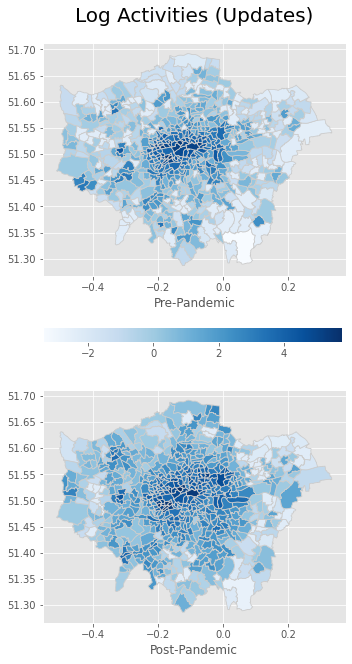

In [169]:
style = "Blues"
# set the value column that will be visualised
variable = 'log_Metric'
# set the range for the choropleth values
vmin, vmax = min(new_polygons1[variable].tolist()+new_polygons2[variable].tolist()), max(new_polygons1[variable].tolist()+new_polygons2[variable].tolist())

# create figure and axes for Matplotlib
fig, ax = plt.subplots(2,1, figsize=(5, 10), sharey='row')

n_rows = 2
n_col = 1
# remove the axis
# ax[0].axis('off')
# ax[1].axis('off')
# add a title and annotation

# ax.set_title('# of Cities per each Region', fontdict={'fontsize': '25', 'fontweight' : '3'})
# ax.annotate('Source: Wikipedia - https://en.wikipedia.org/wiki/Provinces_of_Indonesia', xy=(0.6, .05), xycoords='figure fraction', fontsize=12, color='#555555')

# Create colorbar legend
sm = plt.cm.ScalarMappable(cmap=style, norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm.set_array([]) # or alternatively sm._A = []. Not sure why this step is necessary, but many recommends it
# add the colorbar to the figure
# fig.colorbar(sm, ax=ax.ravel().tolist())
# create map
new_polygons1.plot(column=variable, cmap=style, linewidth=0.8, ax=ax[0], edgecolor='0.8', vmin=vmin, vmax=vmax)
plt.setp(ax[0], xlabel='Pre-Pandemic')
new_polygons2.plot(column=variable, cmap=style, linewidth=0.8, ax=ax[1], edgecolor='0.8', vmin=vmin, vmax=vmax)
plt.setp(ax[1], xlabel='Post-Pandemic')

fig.tight_layout()
#fig.colorbar(sm, orientation="horizontal", fraction=0.036, pad=0.1, aspect = 30, ax=ax.ravel().tolist())
y_title_pos = ax[0].get_position().get_points()[1][1]+(1/n_rows)*0.1
plt.suptitle("Log Activities (Updates)",fontsize=20,y=y_title_pos,x=0.55)
fig.colorbar(sm, ax=ax.ravel().tolist(),aspect = 30, fraction=0.036, cax = fig.add_axes([0.13, 0.5 , 0.83, 0.02]), orientation="horizontal")
#fig.colorbar(sm, ax=ax.ravel().tolist(),aspect = 30, fraction=0.036, cax = fig.add_axes([0.5, 0.12 , 0.02, 0.84]))
plt.savefig("Update_Choropleth_Map.png" ,bbox_inches = 'tight',dpi=200)
# plt.show()

In [170]:
Manchester_new = gpd.read_file('./gdrive/MyDrive/COMP0158/Other_shp_summary_stat/Manchester_new.shp')
Manchester_update = gpd.read_file('./gdrive/MyDrive/COMP0158/Other_shp_summary_stat/Manchester_update.shp')
WM_new = gpd.read_file('./gdrive/MyDrive/COMP0158/Other_shp_summary_stat/WM_new.shp')
WM_update = gpd.read_file('./gdrive/MyDrive/COMP0158/Other_shp_summary_stat/WM_update.shp')

In [ ]:
Manchester_update.head()

,GSS_COD,label,altname,name,pt_cont,area,pre_pdt,update,X,IMD_Scr,slf_rnf,updt_rt,lg_pdt_,sc_max,sc_avg,geometry
0,E36006236,E08000001E36006236,None,Astley Bridge,64,6.577509,0,0,None,None,-2.995732,0.000000,-2.995732,-0.149188,-2.046884,"POLYGON ((-2.45065 53.62779, -2.45055 53.62779..."
1,E36006237,E08000001E36006237,None,Bradshaw,69,9.244972,0,1,None,None,-2.995732,0.108167,-2.224080,-0.149188,-2.639914,"POLYGON ((-2.37913 53.63085, -2.37902 53.63049..."
2,E36006238,E08000001E36006238,None,Breightmet,129,3.699086,0,7,None,None,-2.995732,1.892359,0.637824,-1.637690,-2.656222,"POLYGON ((-2.37690 53.59327, -2.37683 53.59312..."
3,E36006239,E08000001E36006239,None,Bromley Cross,38,6.948989,0,1,None,None,-2.995732,0.143906,-1.938596,-0.149188,-2.046884,"POLYGON ((-2.40538 53.62513, -2.40534 53.62510..."
4,E36006240,E08000001E36006240,None,Crompton,197,3.482675,3,10,None,None,-0.149188,2.871356,1.054784,1.797486,-1.705280,"POLYGON ((-2.40692 53.60025, -2.40703 53.60020..."


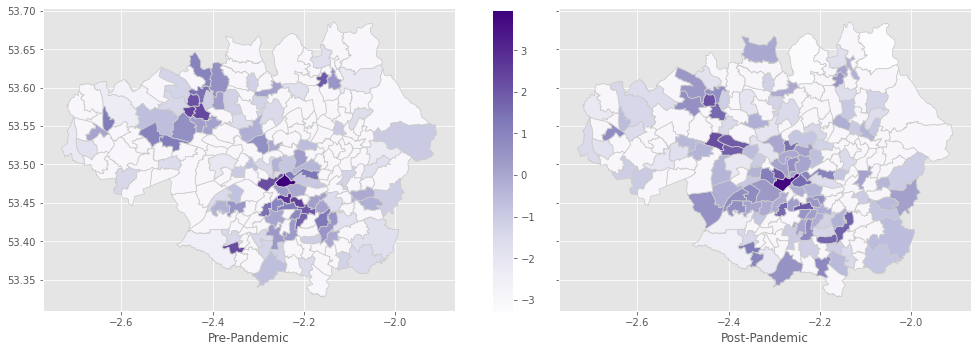

In [171]:
style = "Purples"
plt.style.use('ggplot')
# set the value column that will be visualised
variable_1 = 'slf_rnf'
variable_2 = "lg_nw_r"
# set the range for the choropleth values
vmin, vmax = min(Manchester_new[variable_1].tolist()+Manchester_new[variable_2].tolist()), max(Manchester_new[variable_1].tolist()+Manchester_new[variable_2].tolist())

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1,2, figsize=(15, 5), sharey='row')

n_rows = 1
n_col = 2
# remove the axis
# ax[0].axis('off')
# ax[1].axis('off')
# add a title and annotation

# ax.set_title('# of Cities per each Region', fontdict={'fontsize': '25', 'fontweight' : '3'})
# ax.annotate('Source: Wikipedia - https://en.wikipedia.org/wiki/Provinces_of_Indonesia', xy=(0.6, .05), xycoords='figure fraction', fontsize=12, color='#555555')

# Create colorbar legend
sm = plt.cm.ScalarMappable(cmap=style, norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm.set_array([]) # or alternatively sm._A = []. Not sure why this step is necessary, but many recommends it
# add the colorbar to the figure
# fig.colorbar(sm, ax=ax.ravel().tolist())
# create map
Manchester_new.plot(column=variable_1, cmap=style, linewidth=0.8, ax=ax[0], edgecolor='0.8', vmin=vmin, vmax=vmax)
plt.setp(ax[0], xlabel='Pre-Pandemic')
Manchester_new.plot(column=variable_2, cmap=style, linewidth=0.8, ax=ax[1], edgecolor='0.8', vmin=vmin, vmax=vmax)
plt.setp(ax[1], xlabel='Post-Pandemic')

fig.tight_layout()
#fig.colorbar(sm, orientation="horizontal", fraction=0.036, pad=0.1, aspect = 30, ax=ax.ravel().tolist())
y_title_pos = ax[0].get_position().get_points()[1][1]+(1/n_rows)*0.1
#plt.suptitle("Log Business Activeness",fontsize=20,y=y_title_pos)
# fig.colorbar(sm, ax=ax.ravel().tolist(),aspect = 30, fraction=0.036, cax = fig.add_axes([0.09, 0 , 0.84, 0.02]), orientation="horizontal")
fig.colorbar(sm, ax=ax.ravel().tolist(),aspect = 30, fraction=0.036, cax = fig.add_axes([0.5, 0.12 , 0.02, 0.84]))
plt.savefig("New_Manchester_Choropleth_Map.png" ,bbox_inches = 'tight')
# plt.show()

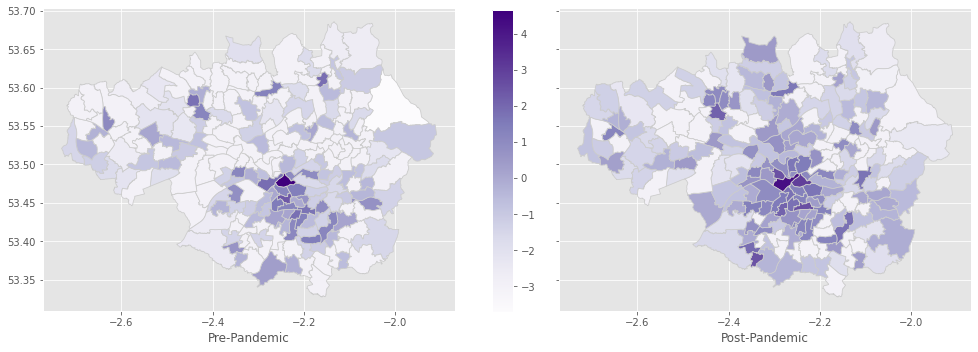

In [172]:
style = "Purples"
plt.style.use('ggplot')
# set the value column that will be visualised
variable_1 = 'slf_rnf'
variable_2 = "lg_pdt_"
# set the range for the choropleth values
vmin, vmax = min(Manchester_update[variable_1].tolist()+Manchester_update[variable_2].tolist()), max(Manchester_update[variable_1].tolist()+Manchester_update[variable_2].tolist())

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1,2, figsize=(15, 5), sharey='row')

n_rows = 1
n_col = 2
# remove the axis
# ax[0].axis('off')
# ax[1].axis('off')
# add a title and annotation

# ax.set_title('# of Cities per each Region', fontdict={'fontsize': '25', 'fontweight' : '3'})
# ax.annotate('Source: Wikipedia - https://en.wikipedia.org/wiki/Provinces_of_Indonesia', xy=(0.6, .05), xycoords='figure fraction', fontsize=12, color='#555555')

# Create colorbar legend
sm = plt.cm.ScalarMappable(cmap=style, norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm.set_array([]) # or alternatively sm._A = []. Not sure why this step is necessary, but many recommends it
# add the colorbar to the figure
# fig.colorbar(sm, ax=ax.ravel().tolist())
# create map
Manchester_update.plot(column=variable_1, cmap=style, linewidth=0.8, ax=ax[0], edgecolor='0.8', vmin=vmin, vmax=vmax)
plt.setp(ax[0], xlabel='Pre-Pandemic')
Manchester_update.plot(column=variable_2, cmap=style, linewidth=0.8, ax=ax[1], edgecolor='0.8', vmin=vmin, vmax=vmax)
plt.setp(ax[1], xlabel='Post-Pandemic')

fig.tight_layout()
#fig.colorbar(sm, orientation="horizontal", fraction=0.036, pad=0.1, aspect = 30, ax=ax.ravel().tolist())
y_title_pos = ax[0].get_position().get_points()[1][1]+(1/n_rows)*0.1
#plt.suptitle("Log Mapping Activeness",fontsize=20,y=y_title_pos)
# fig.colorbar(sm, ax=ax.ravel().tolist(),aspect = 30, fraction=0.036, cax = fig.add_axes([0.09, 0 , 0.84, 0.02]), orientation="horizontal")
fig.colorbar(sm, ax=ax.ravel().tolist(),aspect = 30, fraction=0.036, cax = fig.add_axes([0.5, 0.12 , 0.02, 0.84]))
plt.savefig("Update_Manchester_Choropleth_Map.png" ,bbox_inches = 'tight')
# plt.show()

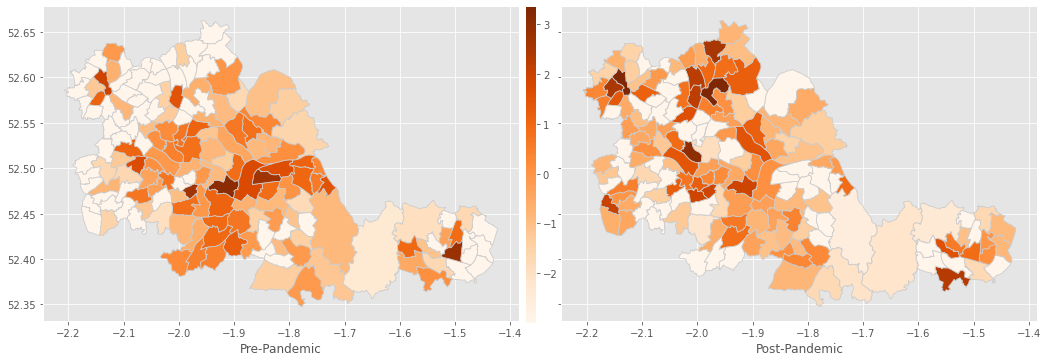

In [174]:
style = "Oranges"
plt.style.use('ggplot')
# set the value column that will be visualised
variable_1 = 'slf_rnf'
variable_2 = "lg_nw_r"
# set the range for the choropleth values
vmin, vmax = min(WM_new[variable_1].tolist()+WM_new[variable_2].tolist()), max(WM_new[variable_1].tolist()+WM_new[variable_2].tolist())

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1,2, figsize=(15, 5), sharey='row')

n_rows = 1
n_col = 2
# remove the axis
# ax[0].axis('off')
# ax[1].axis('off')
# add a title and annotation

# ax.set_title('# of Cities per each Region', fontdict={'fontsize': '25', 'fontweight' : '3'})
# ax.annotate('Source: Wikipedia - https://en.wikipedia.org/wiki/Provinces_of_Indonesia', xy=(0.6, .05), xycoords='figure fraction', fontsize=12, color='#555555')

# Create colorbar legend
sm = plt.cm.ScalarMappable(cmap=style, norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm.set_array([]) # or alternatively sm._A = []. Not sure why this step is necessary, but many recommends it
# add the colorbar to the figure
# fig.colorbar(sm, ax=ax.ravel().tolist())
# create map
WM_new.plot(column=variable_1, cmap=style, linewidth=0.8, ax=ax[0], edgecolor='0.8', vmin=vmin, vmax=vmax)
plt.setp(ax[0], xlabel='Pre-Pandemic')
WM_new.plot(column=variable_2, cmap=style, linewidth=0.8, ax=ax[1], edgecolor='0.8', vmin=vmin, vmax=vmax)
plt.setp(ax[1], xlabel='Post-Pandemic')

fig.tight_layout()
#fig.colorbar(sm, orientation="horizontal", fraction=0.036, pad=0.1, aspect = 30, ax=ax.ravel().tolist())
y_title_pos = ax[0].get_position().get_points()[1][1]+(1/n_rows)*0.1
#plt.suptitle("Log Business Activeness",fontsize=20,y=y_title_pos)
# fig.colorbar(sm, ax=ax.ravel().tolist(),aspect = 30, fraction=0.036, cax = fig.add_axes([0.09, 0 , 0.84, 0.02]), orientation="horizontal")
fig.colorbar(sm, ax=ax.ravel().tolist(),aspect = 30, fraction=0.036, cax = fig.add_axes([0.5, 0.09 , 0.01, 0.88]))
plt.savefig("New_WM_Choropleth_Map.png" ,bbox_inches = 'tight')
# plt.show()

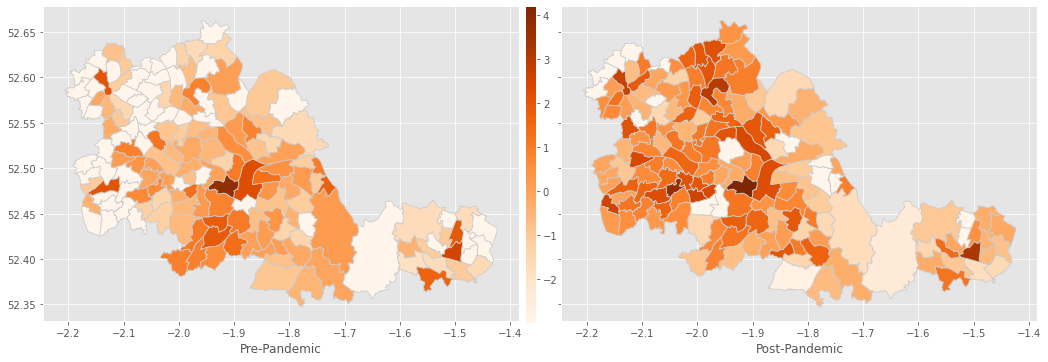

In [173]:
style = "Oranges"
plt.style.use('ggplot')
# set the value column that will be visualised
variable_1 = 'slf_rnf'
variable_2 = "lg_pdt_"
# set the range for the choropleth values
vmin, vmax = min(WM_update[variable_1].tolist()+WM_update[variable_2].tolist()), max(WM_update[variable_1].tolist()+WM_update[variable_2].tolist())

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1,2, figsize=(15, 5), sharey='row')

n_rows = 1
n_col = 2
# remove the axis
# ax[0].axis('off')
# ax[1].axis('off')
# add a title and annotation

# ax.set_title('# of Cities per each Region', fontdict={'fontsize': '25', 'fontweight' : '3'})
# ax.annotate('Source: Wikipedia - https://en.wikipedia.org/wiki/Provinces_of_Indonesia', xy=(0.6, .05), xycoords='figure fraction', fontsize=12, color='#555555')

# Create colorbar legend
sm = plt.cm.ScalarMappable(cmap=style, norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm.set_array([]) # or alternatively sm._A = []. Not sure why this step is necessary, but many recommends it
# add the colorbar to the figure
# fig.colorbar(sm, ax=ax.ravel().tolist())
# create map
WM_update.plot(column=variable_1, cmap=style, linewidth=0.8, ax=ax[0], edgecolor='0.8', vmin=vmin, vmax=vmax)
plt.setp(ax[0], xlabel='Pre-Pandemic')
WM_update.plot(column=variable_2, cmap=style, linewidth=0.8, ax=ax[1], edgecolor='0.8', vmin=vmin, vmax=vmax)
plt.setp(ax[1], xlabel='Post-Pandemic')

fig.tight_layout()
#fig.colorbar(sm, orientation="horizontal", fraction=0.036, pad=0.1, aspect = 30, ax=ax.ravel().tolist())
y_title_pos = ax[0].get_position().get_points()[1][1]+(1/n_rows)*0.1
#plt.suptitle("Log Mapping Activeness",fontsize=20,y=y_title_pos)
# fig.colorbar(sm, ax=ax.ravel().tolist(),aspect = 30, fraction=0.036, cax = fig.add_axes([0.09, 0 , 0.84, 0.02]), orientation="horizontal")
fig.colorbar(sm, ax=ax.ravel().tolist(),aspect = 30, fraction=0.036, cax = fig.add_axes([0.5, 0.09 , 0.01, 0.88]))
plt.savefig("Update_WM_Choropleth_Map.png" ,bbox_inches = 'tight')
# plt.show()

# England Map

In [ ]:
London = gpd.read_file('./gdrive/MyDrive/COMP0158/London_2011/London_Ward_CityMerged.shp')
Manchester = gpd.read_file('./gdrive/MyDrive/COMP0158/UK_SHP_2011/england_cmwd_2011.shp')
West_Midland = gpd.read_file('./gdrive/MyDrive/COMP0158/UK_SHP_2011/england_cmwd_2011 (1).shp')
GB = gpd.read_file('./gdrive/MyDrive/COMP0158/UK_SHP_2011/england_ol_2011.shp')

London = London.to_crs(4326)
Manchester = Manchester.to_crs(4326)
West_Midland = West_Midland.to_crs(4326)
GB = GB.to_crs(4326)

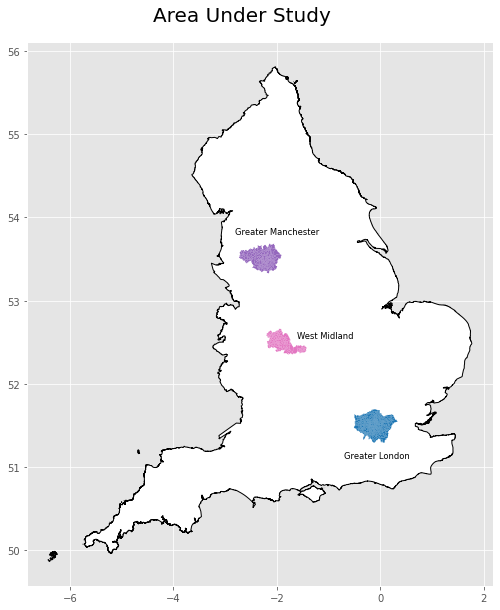

In [ ]:
fig, ax = plt.subplots(1, figsize=(20, 10))
plt.style.use('ggplot')
n_rows=1
#ax.axis('off')
GB.plot(ax=ax,linewidth=1.,facecolor="white",edgecolor='black')
West_Midland.plot(ax=ax,linewidth=0.8,facecolor="tab:pink",label = "West Midland",legend=True)
Manchester.plot(ax=ax,linewidth=0.8,facecolor="tab:purple",label = "West Midland",legend=True)
London.plot(ax=ax,linewidth=0.8,facecolor="tab:blue",label = "West Midland",legend=True)

ax.text(-0.7, 51.1, "Greater London", transform=ax.transData,fontsize="small")
ax.text(-1.6, 52.55, "West Midland", transform=ax.transData,fontsize="small")
ax.text(-2.8, 53.8, "Greater Manchester", transform=ax.transData,fontsize="small")

y_title_pos = ax.get_position().get_points()[1][1]+(1/n_rows)*0.05
plt.suptitle("Area Under Study",fontsize=20,y=y_title_pos)

#plt.legend()
#plt.show()
plt.savefig("UK_Map.png" ,bbox_inches = 'tight',dpi=300)

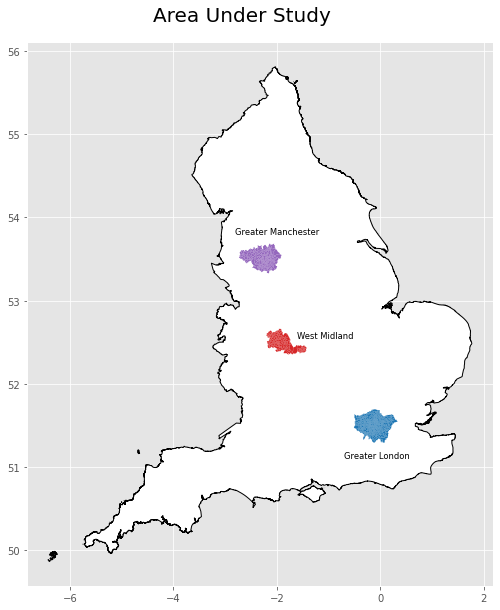

In [ ]:
fig, ax = plt.subplots(1, figsize=(20, 10))
plt.style.use('ggplot')
n_rows=1
#ax.axis('off')
GB.plot(ax=ax,linewidth=1.,facecolor="white",edgecolor='black')
West_Midland.plot(ax=ax,linewidth=0.8,facecolor="tab:red",label = "West Midland",legend=True)
Manchester.plot(ax=ax,linewidth=0.8,facecolor="tab:purple",label = "West Midland",legend=True)
London.plot(ax=ax,linewidth=0.8,facecolor="tab:blue",label = "West Midland",legend=True)

ax.text(-0.7, 51.1, "Greater London", transform=ax.transData,fontsize="small")
ax.text(-1.6, 52.55, "West Midland", transform=ax.transData,fontsize="small")
ax.text(-2.8, 53.8, "Greater Manchester", transform=ax.transData,fontsize="small")

y_title_pos = ax.get_position().get_points()[1][1]+(1/n_rows)*0.05
plt.suptitle("Area Under Study",fontsize=20,y=y_title_pos)

#plt.legend()
#plt.show()
plt.savefig("UK_Map.png" ,bbox_inches = 'tight',dpi=300)

In [ ]:
GB = gpd.read_file('./gdrive/MyDrive/COMP0158/UK_SHP_2011/england_wa_2011.shp')